In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import train_test_split
#from sklearn.svm import SVC
from cuml.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")


from sklearn import set_config

set_config(display="diagram")

In [2]:
#Original
features_C_NMC = np.load('../input/pca-pretraining-featureextraction-resnet-c-nmc/C_NMC_ExtractedFeatures.npy')
labels_C_NMC = np.load('../input/pca-pretraining-featureextraction-resnet-c-nmc/Targets.npy')
labels_C_NMC = [np.argmax(y, axis=None, out=None) for y in labels_C_NMC]
labels_C_NMC = np.asarray(labels_C_NMC)

#Jaya
featuresIndex_C_NMC_Jaya_100iter = np.load('../input/featureselection-jaya-c-nmc/SelectedFeaturesIndexs_C_NMC_ResNet_100iter.npy')
features_C_NMC_Jaya_100iter = features_C_NMC[:, featuresIndex_C_NMC_Jaya_100iter]

print("Features Jaya C-NMC 100iter Shape: ", features_C_NMC_Jaya_100iter.shape)
print("Labels C-NMC Shape: ", labels_C_NMC.shape)

Features Jaya C-NMC 100iter Shape:  (8410, 1080)
Labels C-NMC Shape:  (8410,)


 ### **SVM Classification**

Fold :  1  Accuracy:  0.9875178316690443  Precision:  0.9865724381625441  Recall:  0.9886685552407932  F1-Score:  0.9876193845065441  AUC:  0.9875095649767184
---------------------------------------------------------
Fold :  2  Accuracy:  0.986086336068498  Precision:  0.9928571428571429  Recall:  0.9795630725863284  F1-Score:  0.9861653068463995  AUC:  0.9861688195301583
---------------------------------------------------------
Fold :  3  Accuracy:  0.9917945058865502  Precision:  0.9948567229977957  Recall:  0.9883211678832117  F1-Score:  0.9915781764921273  AUC:  0.9917181554698683
---------------------------------------------------------


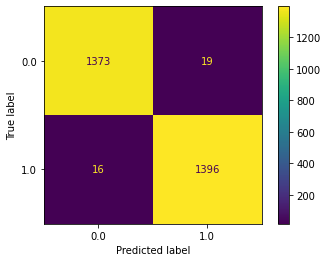

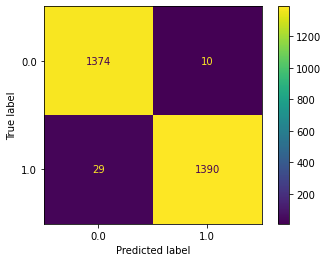

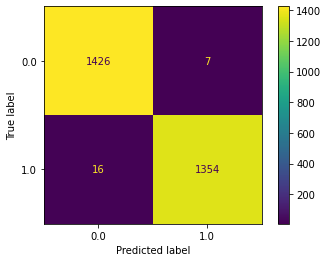

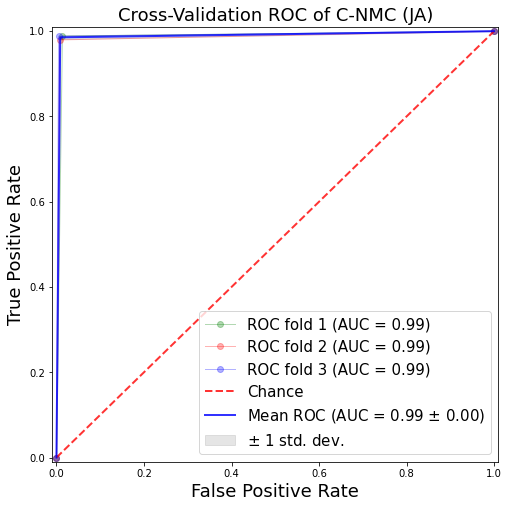

In [3]:
tprs = []
aucs = []
fprs = []
# Define per-fold score containers <-- these are new
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1score_per_fold = []
num_folds = 3
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(features_C_NMC_Jaya_100iter, labels_C_NMC):
    clf = None
    clf = SVC(kernel='rbf', C=10, gamma=0.01, random_state=0)
    clf.fit(features_C_NMC_Jaya_100iter[train], labels_C_NMC[train])
    preds = clf.predict(features_C_NMC_Jaya_100iter[test])
    precision = precision_score(labels_C_NMC[test], preds)
    recall = recall_score(labels_C_NMC[test], preds)
    accuracy = accuracy_score(labels_C_NMC[test], preds)
    f1 = f1_score(labels_C_NMC[test], preds)
    fpr, tpr, thresholds = roc_curve(labels_C_NMC[test], preds)
    auc_fold = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(auc_fold)
    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1score_per_fold.append(f1)
    print("Fold : ", fold_no, " Accuracy: ", accuracy, " Precision: ", precision, " Recall: ", recall, " F1-Score: ", f1, " AUC: ", auc_fold)
    _ = plot_confusion_matrix(clf, features_C_NMC_Jaya_100iter[test], labels_C_NMC[test])
    print("---------------------------------------------------------")
    fold_no = fold_no + 1

cv3_results_JA_C_NMC_100iter = pd.DataFrame(data={"Accuracy": accuracy_per_fold, "Precision": precision_per_fold, "Recall": recall_per_fold, "F1-Score": f1score_per_fold, " AUC": aucs})
cv3_results_JA_C_NMC_100iter.to_csv("./cv3_results_JA_C_NMC_100iter.csv")
cv3_results_JA_C_NMC_100iter.head()

plt.figure(figsize=(8,8))
plt.plot(fprs[0], tprs[0], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[0]))
plt.plot(fprs[1], tprs[1], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (2, aucs[1]))
plt.plot(fprs[2], tprs[2], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (3, aucs[2]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.mean(fprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of C-NMC (JA)',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

Fold :  1  Accuracy:  0.9910820451843044  Precision:  0.9927623642943305  Recall:  0.9891826923076923  F1-Score:  0.9909692956050572  AUC:  0.9910619343891403
---------------------------------------------------------
Fold :  2  Accuracy:  0.9881093935790726  Precision:  0.9940828402366864  Recall:  0.9824561403508771  F1-Score:  0.988235294117647  AUC:  0.9882050955684253
---------------------------------------------------------
Fold :  3  Accuracy:  0.9916765755053508  Precision:  0.9940968122786304  Recall:  0.9894242068155111  F1-Score:  0.9917550058892814  AUC:  0.9917036798217146
---------------------------------------------------------
Fold :  4  Accuracy:  0.9892984542211652  Precision:  0.9951040391676866  Recall:  0.9830713422007256  F1-Score:  0.9890510948905109  AUC:  0.989196489813813
---------------------------------------------------------
Fold :  5  Accuracy:  0.9821640903686087  Precision:  0.9867149758454107  Recall:  0.9772727272727273  F1-Score:  0.9819711538461539  

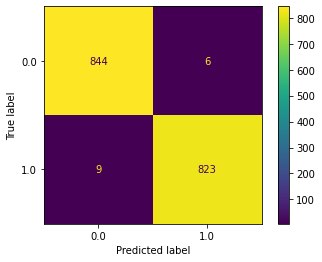

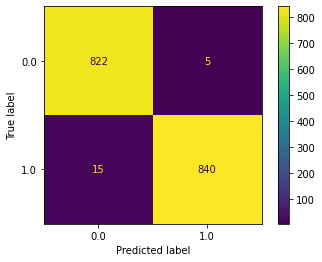

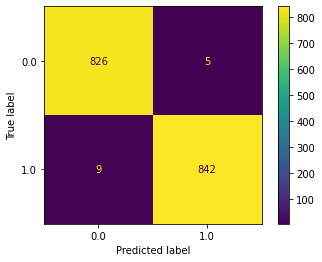

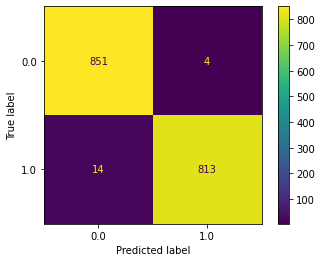

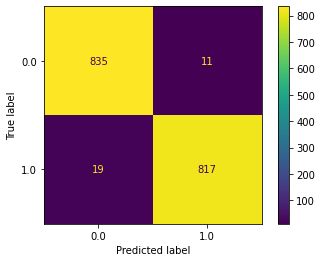

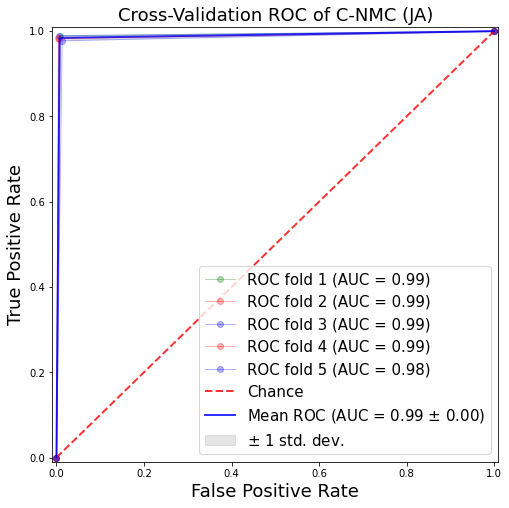

In [4]:
tprs = []
aucs = []
fprs = []
# Define per-fold score containers <-- these are new
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1score_per_fold = []
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(features_C_NMC_Jaya_100iter, labels_C_NMC):
    clf = None
    clf = SVC(kernel='rbf', C=10, gamma=0.01, random_state=0)
    clf.fit(features_C_NMC_Jaya_100iter[train], labels_C_NMC[train])
    preds = clf.predict(features_C_NMC_Jaya_100iter[test])
    precision = precision_score(labels_C_NMC[test], preds)
    recall = recall_score(labels_C_NMC[test], preds)
    accuracy = accuracy_score(labels_C_NMC[test], preds)
    f1 = f1_score(labels_C_NMC[test], preds)
    fpr, tpr, thresholds = roc_curve(labels_C_NMC[test], preds)
    auc_fold = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(auc_fold)
    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1score_per_fold.append(f1)
    print("Fold : ", fold_no, " Accuracy: ", accuracy, " Precision: ", precision, " Recall: ", recall, " F1-Score: ", f1, " AUC: ", auc_fold)
    _ = plot_confusion_matrix(clf, features_C_NMC_Jaya_100iter[test], labels_C_NMC[test])
    print("---------------------------------------------------------")
    fold_no = fold_no + 1

cv5_results_JA_C_NMC_100iter = pd.DataFrame(data={"Accuracy": accuracy_per_fold, "Precision": precision_per_fold, "Recall": recall_per_fold, "F1-Score": f1score_per_fold, " AUC": aucs})
cv5_results_JA_C_NMC_100iter.to_csv("./cv5_results_JA_C_NMC_100iter.csv")
cv5_results_JA_C_NMC_100iter.head()

plt.figure(figsize=(8,8))
plt.plot(fprs[0], tprs[0], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[0]))
plt.plot(fprs[1], tprs[1], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (2, aucs[1]))
plt.plot(fprs[2], tprs[2], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (3, aucs[2]))
plt.plot(fprs[3], tprs[3], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (4, aucs[3]))
plt.plot(fprs[4], tprs[4], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (5, aucs[4]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.mean(fprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of C-NMC (JA)',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

Fold :  1  Accuracy:  0.9916765755053508  Precision:  0.9952718676122931  Recall:  0.9882629107981221  F1-Score:  0.9917550058892814  AUC:  0.9917218168448442
---------------------------------------------------------
Fold :  2  Accuracy:  0.9940546967895363  Precision:  0.9974489795918368  Recall:  0.9898734177215189  F1-Score:  0.9936467598475222  AUC:  0.9938156326275757
---------------------------------------------------------
Fold :  3  Accuracy:  0.9869203329369798  Precision:  0.9873737373737373  Recall:  0.9848866498740554  F1-Score:  0.9861286254728877  AUC:  0.9868126943063971
---------------------------------------------------------
Fold :  4  Accuracy:  0.9845422116527943  Precision:  0.9931192660550459  Recall:  0.9774266365688488  F1-Score:  0.9852104664391353  AUC:  0.9849444740633189
---------------------------------------------------------
Fold :  5  Accuracy:  0.990487514863258  Precision:  0.9951100244498777  Recall:  0.9854721549636803  F1-Score:  0.9902676399026764 

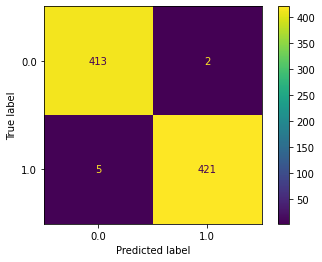

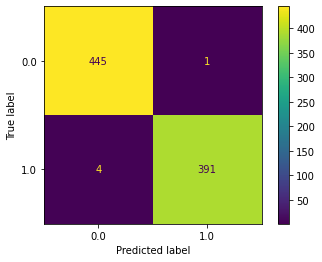

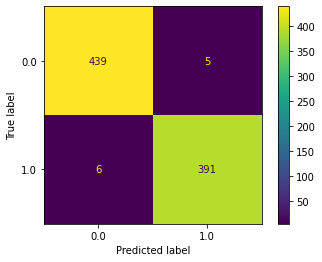

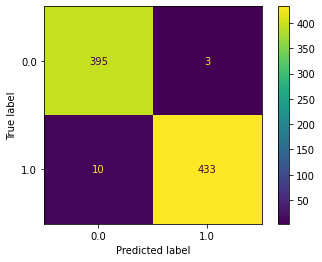

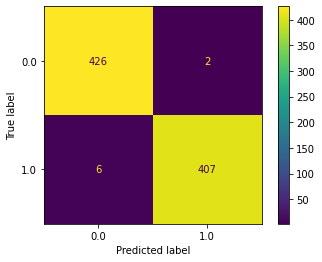

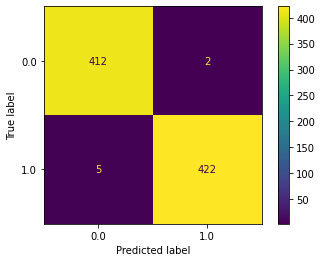

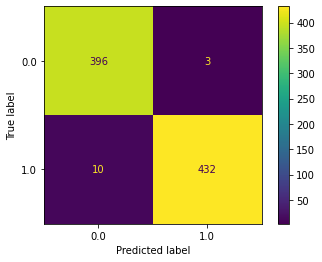

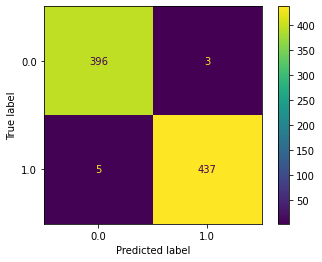

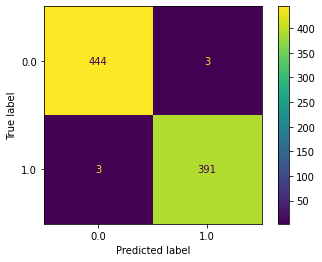

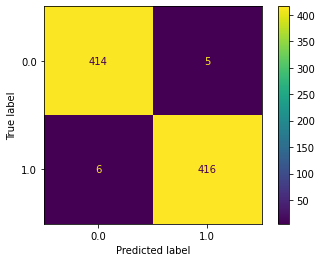

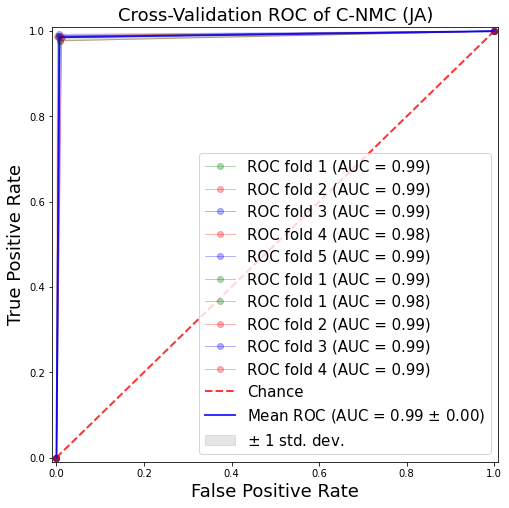

In [5]:
tprs = []
aucs = []
fprs = []
# Define per-fold score containers <-- these are new
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1score_per_fold = []
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(features_C_NMC_Jaya_100iter, labels_C_NMC):
    clf = None
    clf = SVC(kernel='rbf', C=10, gamma=0.01, random_state=0)
    clf.fit(features_C_NMC_Jaya_100iter[train], labels_C_NMC[train])
    preds = clf.predict(features_C_NMC_Jaya_100iter[test])
    precision = precision_score(labels_C_NMC[test], preds)
    recall = recall_score(labels_C_NMC[test], preds)
    accuracy = accuracy_score(labels_C_NMC[test], preds)
    f1 = f1_score(labels_C_NMC[test], preds)
    fpr, tpr, thresholds = roc_curve(labels_C_NMC[test], preds)
    auc_fold = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(auc_fold)
    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1score_per_fold.append(f1)
    print("Fold : ", fold_no, " Accuracy: ", accuracy, " Precision: ", precision, " Recall: ", recall, " F1-Score: ", f1, " AUC: ", auc_fold)
    _ = plot_confusion_matrix(clf, features_C_NMC_Jaya_100iter[test], labels_C_NMC[test])
    print("---------------------------------------------------------")
    fold_no = fold_no + 1

cv10_results_JA_C_NMC_100iter = pd.DataFrame(data={"Accuracy": accuracy_per_fold, "Precision": precision_per_fold, "Recall": recall_per_fold, "F1-Score": f1score_per_fold, " AUC": aucs})
cv10_results_JA_C_NMC_100iter.to_csv("./cv10_results_JA_C_NMC_100iter.csv")
cv10_results_JA_C_NMC_100iter.head()

plt.figure(figsize=(8,8))
plt.plot(fprs[0], tprs[0], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[0]))
plt.plot(fprs[1], tprs[1], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (2, aucs[1]))
plt.plot(fprs[2], tprs[2], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (3, aucs[2]))
plt.plot(fprs[3], tprs[3], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (4, aucs[3]))
plt.plot(fprs[4], tprs[4], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (5, aucs[4]))
plt.plot(fprs[5], tprs[5], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[5]))
plt.plot(fprs[6], tprs[6], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[6]))
plt.plot(fprs[7], tprs[7], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (2, aucs[7]))
plt.plot(fprs[8], tprs[8], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (3, aucs[8]))
plt.plot(fprs[9], tprs[9], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (4, aucs[9]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.mean(fprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of C-NMC (JA)',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()